# Chapter 10: Suppressing and Mitigating Quantum Noise

In [1]:
# Load helper file
%run helper_file_1.0.ipynb

# Qiskit Runtime Service


In [21]:
# Create a simple circuit:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution

q_reg = QuantumRegister(4, name="qr")
c_reg = ClassicalRegister(4, name="cr")

qc = QuantumCircuit(q_reg, c_reg)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)

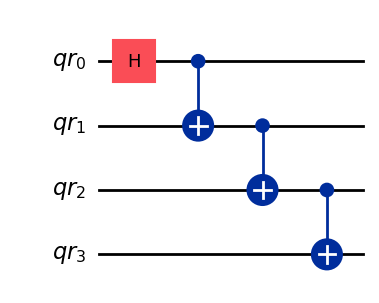

In [22]:
qc.draw(output="mpl", idle_wires=False, style="iqp")

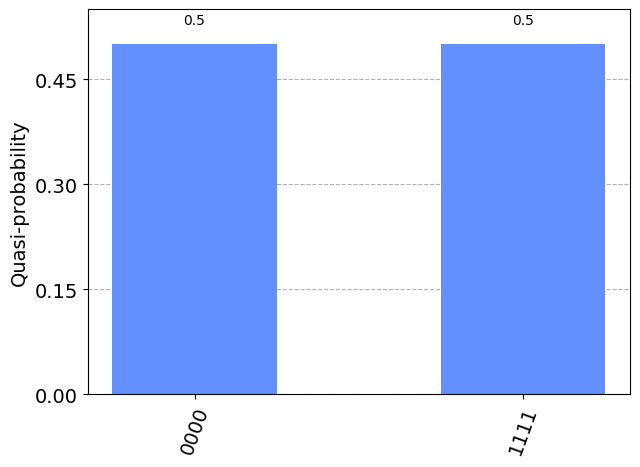

In [23]:
# A Statevector could be used to compute a circuit's expected results
from qiskit.quantum_info import Statevector

results = Statevector.from_instruction(qc).probabilities_dict()

plot_distribution(results)

In [24]:
#Add measurements to run on live system and get results: 
qc.measure_all(add_bits=False)

In [7]:
# Select the least busy backend you have access to
backend = service.least_busy(simulator=False, operational=True)
print('Least busy backend: ', backend)

Least busy backend:  <IBMBackend('ibm_sherbrooke')>


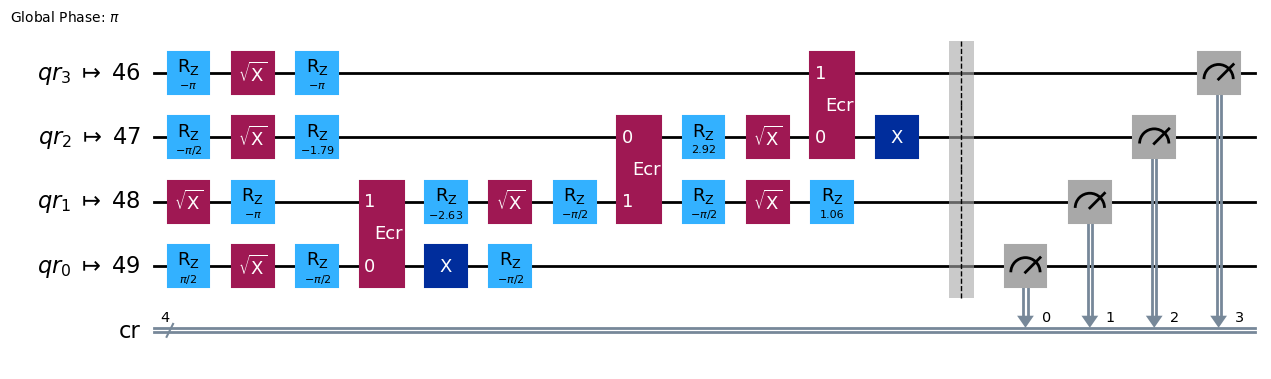

In [8]:
# Optimize for execution
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

transpiled_qc = pm.run(qc)
transpiled_qc.draw(output="mpl", idle_wires=False, style="iqp")

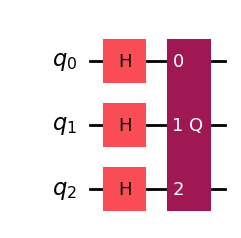

In [27]:
# Create a slightly more complex circuit using Grovers 
from qiskit.circuit.library import GroverOperator

oracle = Statevector.from_label('110')
grover_qc = QuantumCircuit(3)
grover_qc.h(range(3))
grover_qc = grover_qc.compose(GroverOperator(oracle))

grover_qc.draw(output="mpl", style="iqp")

In [20]:
results = Statevector.from_instruction(grover_qc).probabilities_dict()

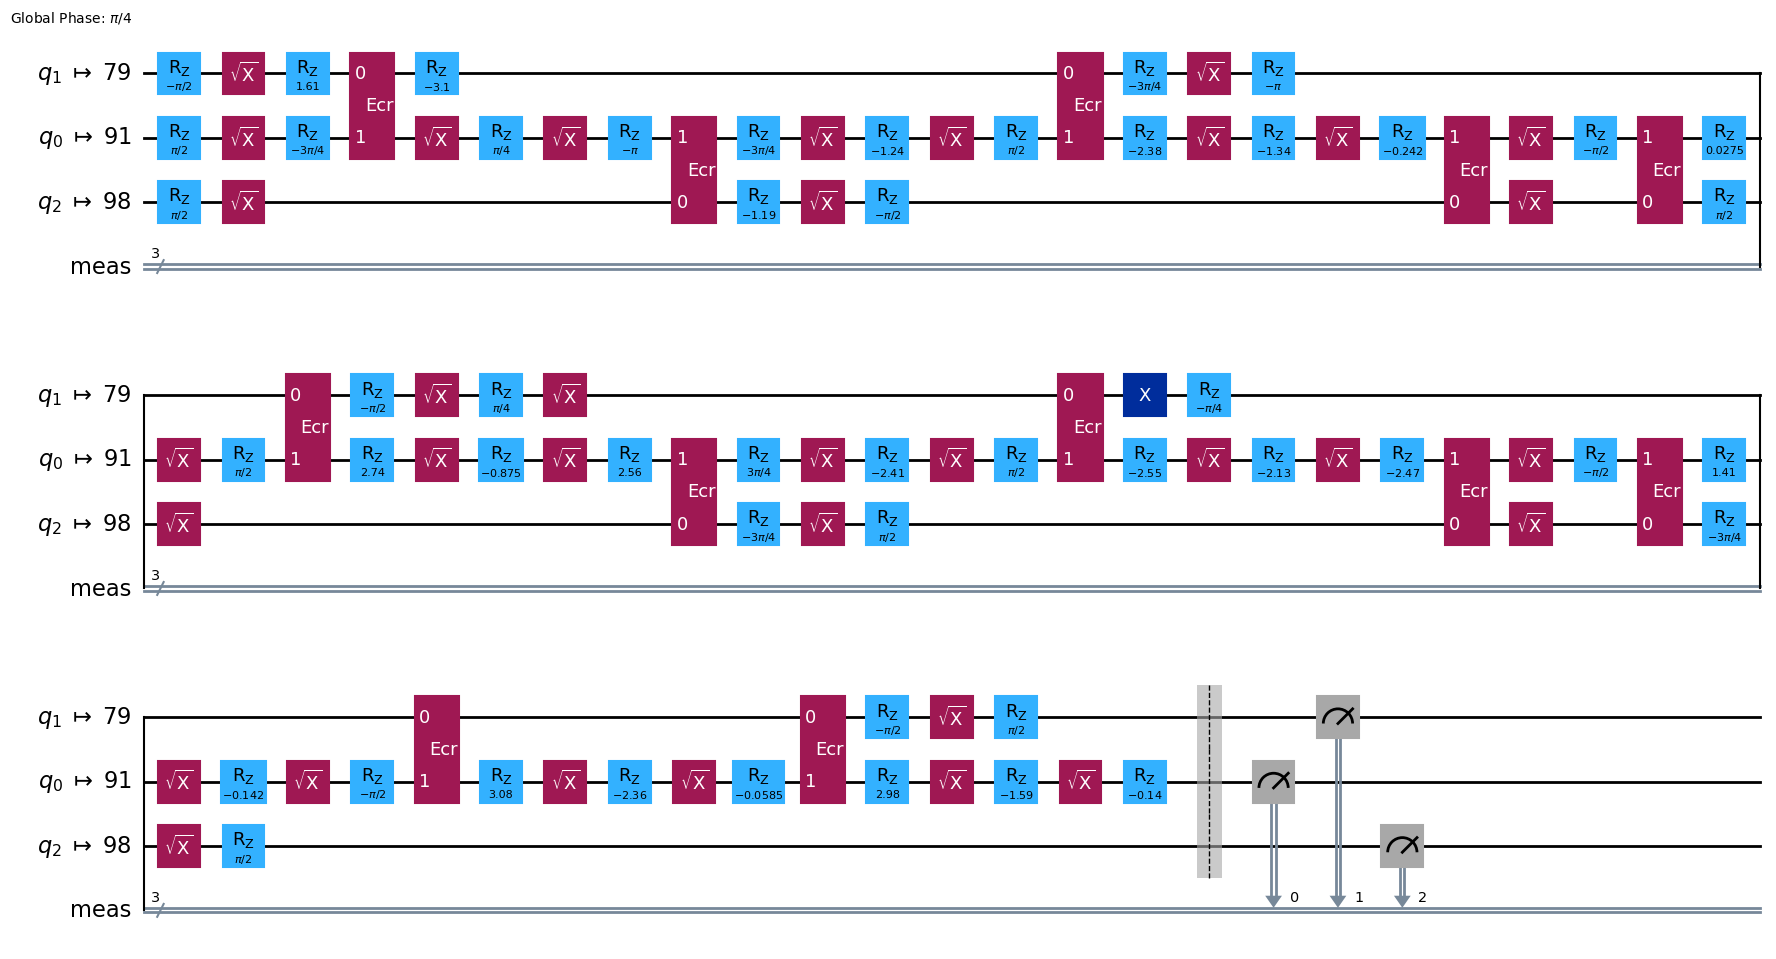

In [10]:
grover_qc.measure_all()

transpiled_grovers_qc = pm.run(grover_qc)
transpiled_grovers_qc.draw(output="mpl", idle_wires=False, style="iqp")

In [11]:
# Create some random circuits with varying optimization levels
circuits = []
# Using the same circuit, transpile each to a different optimization level
for optimization_level in [0, 3]:
    transpiled_grover_qc = transpile(grover_qc, backend, optimization_level=optimization_level, seed_transpiler=1000)
    print(f"ECRs (optimization_level={optimization_level}): ", transpiled_grover_qc.count_ops()["ecr"])
    circuits.append(transpiled_grover_qc)

ECRs (optimization_level=0):  24
ECRs (optimization_level=3):  14


In [12]:
with Batch(service=service, backend=backend):
    sampler = Sampler()
    job = sampler.run(
        circuits=circuits,  # sample all three circuits
        skip_transpilation=True,
        shots=8000,
    )
    result = job.result()

In [13]:
print(result)

SamplerResult(quasi_dists=[{0: 0.136596417234717, 1: 0.057482039100449, 2: 0.03807773583055, 3: 0.051080549862785, 4: 0.028575374054239, 5: 0.068434342226471, 6: 0.540689745421478, 7: 0.079063796269311}, {0: 0.013241830253957, 1: 0.044991185036454, 2: 0.066493715476242, 3: 0.033981414166734, 4: 0.077452855226391, 5: 0.045273457404358, 6: 0.654480551636603, 7: 0.064084990799261}], metadata=[{'shots': 8000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2784314899265776, 'readout_mitigation_time': 0.03348202304914594}, {'shots': 8000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0800027370262115, 'readout_mitigation_time': 0.0965154911391437}])


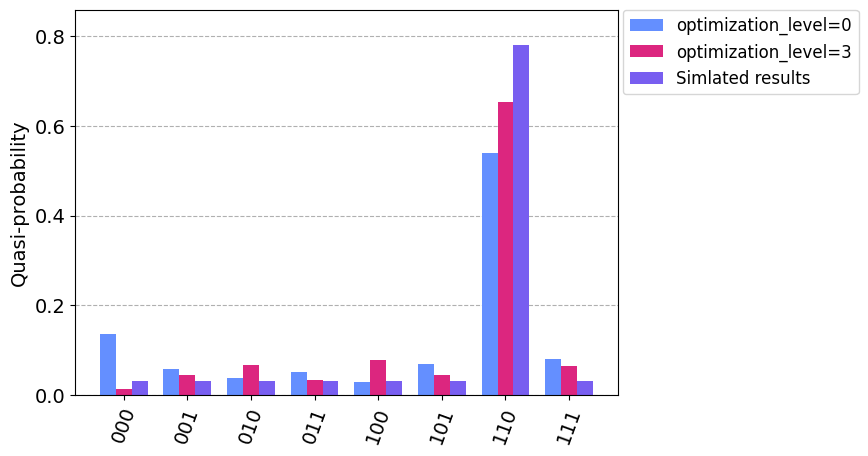

In [21]:
qc_results = [quasi_dist.binary_probabilities() for quasi_dist in result.quasi_dists]
plot_histogram(
    qc_results + [results],
    legend=[
        "optimization_level=0",
        "optimization_level=3",
        "Simulated results",
    ],
    bar_labels=False
)

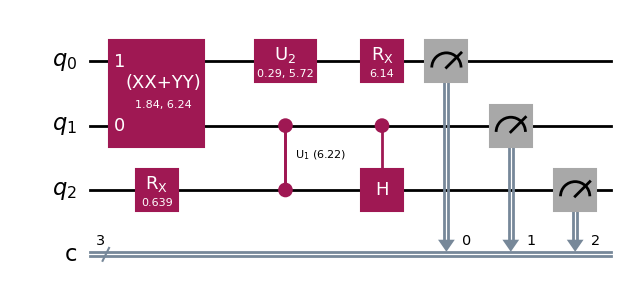

In [22]:
from qiskit.circuit.random import random_circuit

# Create a random circuit
qc2 = random_circuit(3, 3, measure=True)
qc2.draw(output='mpl')

In [23]:
target = backend.target
pass_mgr = generate_preset_pass_manager(target=target, optimization_level=3)

transpiled_qc2 = pass_mgr.run(qc2)
circuits.append(transpiled_qc2)

with Batch(service=service, backend=backend):
    sampler = Sampler()
    job = sampler.run(
        circuits=circuits, 
        skip_transpilation=True,
        shots=8000
    )
    result = job.result()

In [24]:
print(result)

SamplerResult(quasi_dists=[{0: 0.137307023415438, 1: 0.075604581828835, 2: 0.035367028235546, 3: 0.045461401727022, 4: 0.033346487801554, 5: 0.066196568109179, 6: 0.532223423514926, 7: 0.0744934853675}, {0: 0.015269108032948, 1: 0.049902021007236, 2: 0.062831047383745, 3: 0.031877601963831, 4: 0.071870661850113, 5: 0.038418352863499, 6: 0.660427112566284, 7: 0.069404094332343}, {0: 0.361502187961807, 1: 0.535694149055519, 2: 0.001638917755244, 3: 0.001208098005435, 4: 0.034525088718939, 5: 0.055353086798554, 6: 0.002556032271583, 7: 0.007522439432919}], metadata=[{'shots': 8000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2202635614033013, 'readout_mitigation_time': 0.11192018911242485}, {'shots': 8000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0829984626581945, 'readout_mitigation_time': 0.18297958001494408}, {'shots': 8000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.1516417474574598, 'readout_mitigation_time': 0.11047419300302863}])


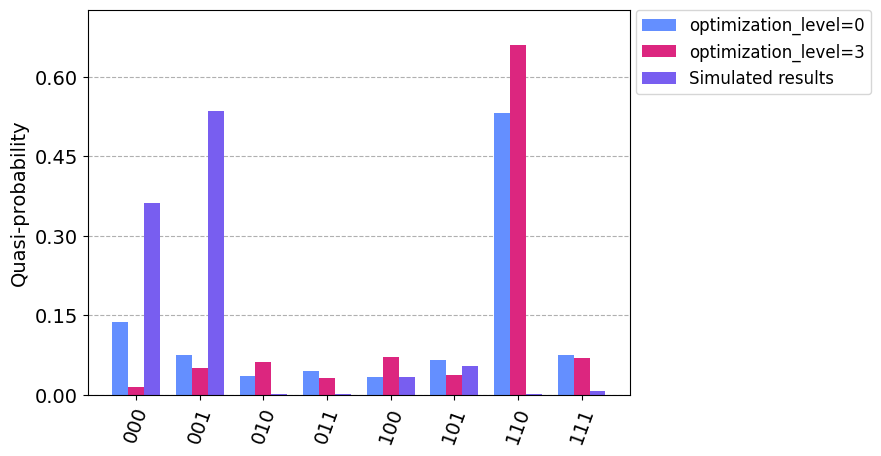

In [26]:
binary_prob = [quasi_dist.binary_probabilities() for quasi_dist in result.quasi_dists]
plot_histogram(
    binary_prob,
    bar_labels=False,
    legend=[
        "optimization_level=0",
        "optimization_level=3",
        #"optimization_level=3 + dd",
        "Simulated results",
    ],
)

# Supressing and Mitigating Noise

# Error Suppression 

In [3]:
import numpy as np
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
from qiskit.visualization import timeline_drawer

In [4]:
# Select the least busy system
backend = service.least_busy(simulator=False, operational=True)

# Pull and print the duration times of the backend system for each get per qubit:
dur = InstructionDurations.from_backend(backend)
print(dur)

id(0,): 6e-08 s
id(1,): 6e-08 s
id(2,): 6e-08 s
id(3,): 6e-08 s
id(4,): 6e-08 s
id(5,): 6e-08 s
id(6,): 6e-08 s
id(7,): 6e-08 s
id(8,): 6e-08 s
id(9,): 6e-08 s
id(10,): 6e-08 s
id(11,): 6e-08 s
id(12,): 6e-08 s
id(13,): 6e-08 s
id(14,): 6e-08 s
id(15,): 6e-08 s
id(16,): 6e-08 s
id(17,): 6e-08 s
id(18,): 6e-08 s
id(19,): 6e-08 s
id(20,): 6e-08 s
id(21,): 6e-08 s
id(22,): 6e-08 s
id(23,): 6e-08 s
id(24,): 6e-08 s
id(25,): 6e-08 s
id(26,): 6e-08 s
id(27,): 6e-08 s
id(28,): 6e-08 s
id(29,): 6e-08 s
id(30,): 6e-08 s
id(31,): 6e-08 s
id(32,): 6e-08 s
id(33,): 6e-08 s
id(34,): 6e-08 s
id(35,): 6e-08 s
id(36,): 6e-08 s
id(37,): 6e-08 s
id(38,): 6e-08 s
id(39,): 6e-08 s
id(40,): 6e-08 s
id(41,): 6e-08 s
id(42,): 6e-08 s
id(43,): 6e-08 s
id(44,): 6e-08 s
id(45,): 6e-08 s
id(46,): 6e-08 s
id(47,): 6e-08 s
id(48,): 6e-08 s
id(49,): 6e-08 s
id(50,): 6e-08 s
id(51,): 6e-08 s
id(52,): 6e-08 s
id(53,): 6e-08 s
id(54,): 6e-08 s
id(55,): 6e-08 s
id(56,): 6e-08 s
id(57,): 6e-08 s
id(58,): 6e-08 s
id(59,)

In [5]:
# Set the duration times for each gate.
custom_duration_times = InstructionDurations([('x', None, 100), 
                                              ('h', 0, 100),
                                              ("cx", [0, 1], 200), 
                                              ("cx", [1, 2], 200),  
                                              ("cx", [2, 3], 200),
                                              ("measure", None, 500
                                                  )])

# Print the timescales for each gate we set:
print(custom_duration_times)

x: 100 dt
measure: 500 dt
h(0,): 100 dt
cx(0, 1): 200 dt
cx(1, 2): 200 dt
cx(2, 3): 200 dt



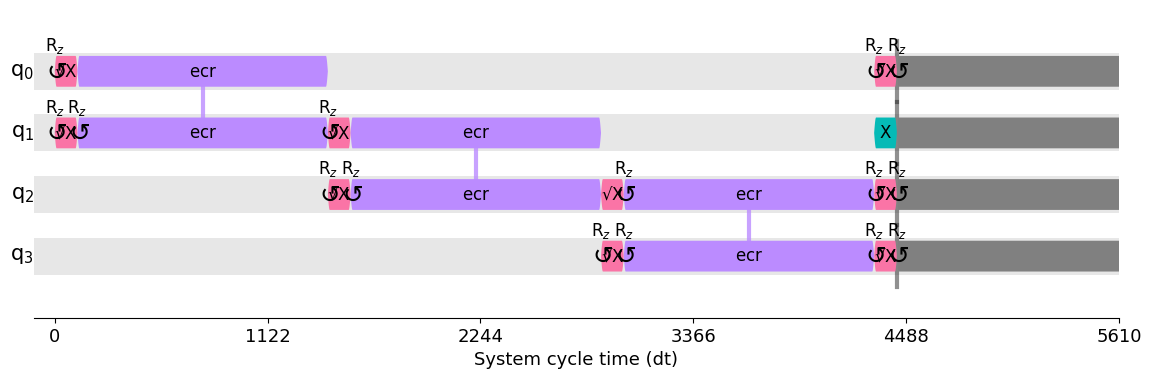

In [25]:
#Let's transpile and add specific scheduling and layout methods to the circuit we created at the start of this notebook 
#and view the default timeline
transpiled_qc = transpile(qc, backend, scheduling_method='alap', layout_method='trivial')
timeline_drawer(transpiled_qc, time_range=[0,5500], show_idle=False)

In [26]:
# Create the Dynamical Decoupling sequence of reversible gates, let's use XGates:
rev_gates = [XGate(), XGate()]

# Set the PassManager with the Dynamical Decoupling sequence and custom duration times
pm = PassManager([ALAPScheduleAnalysis(custom_duration_times),
                  PadDynamicalDecoupling(custom_duration_times, rev_gates)])

In [27]:
# Run the circuit through the PassManager to add the DD to the transpiled circuit
qc_dynamical_decoupling = pm.run(transpiled_qc) 

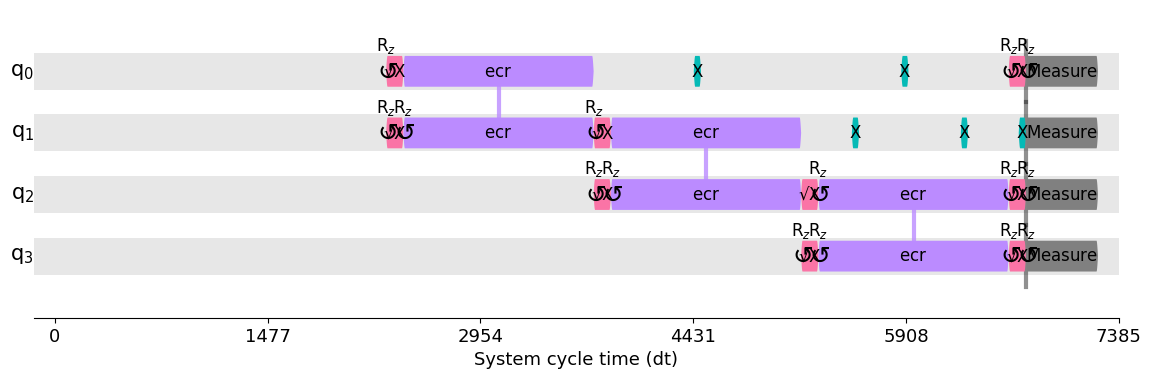

In [29]:
timeline_drawer(qc_dynamical_decoupling, show_idle=False)

In [45]:
# Update durations
updated_values = [('x', None, 1500)]
updated_durations = custom_duration_times.update(updated_values)
print(updated_durations)

x: 1500 dt
measure: 500 dt
h(0,): 100 dt
cx(0, 1): 200 dt
cx(1, 2): 200 dt
cx(2, 3): 200 dt



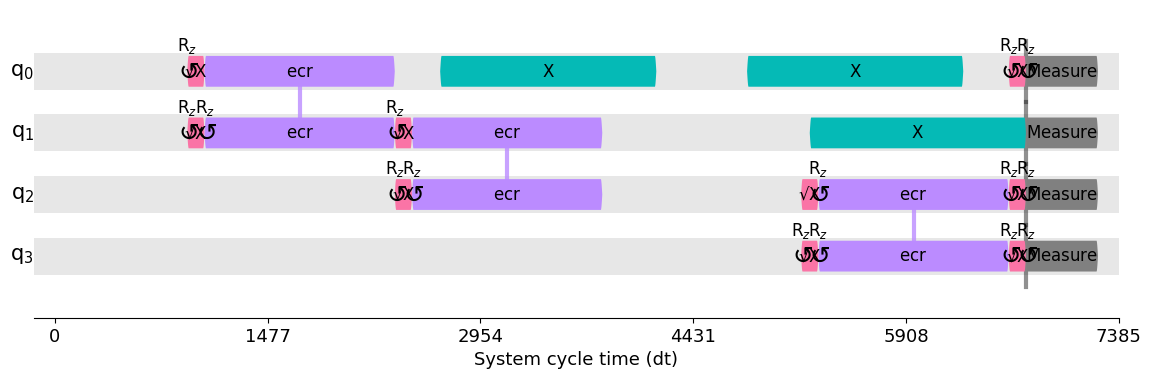

In [46]:
# Create the Dynamical Decoupling sequence of reversible gates, let's use XGates:
#rev_gates = [XGate(), XGate()]

# Set the PassManager with the Dynamical Decoupling sequence and custom duration times
pm = PassManager([ALAPScheduleAnalysis(updated_durations),
                  PadDynamicalDecoupling(updated_durations, rev_gates)])
qc_dynamical_decoupling = pm.run(transpiled_qc)
timeline_drawer(qc_dynamical_decoupling, show_idle=False)

# Applying Error Suppression and Error Mitigation 


In [32]:
#Retrieve the least busy device, filter using backend parameters
least_busy_backend = service.least_busy(simulator=False, operational=True, min_num_qubits=transpiled_qc.num_qubits)
print('Least busy backend: ', least_busy_backend)

# Transpile the circuit to the new backend. 
transpiled_qc = transpile(qc, backend=least_busy_backend)


Least busy backend:  <IBMBackend('ibm_kyoto')>


In [33]:
options = Options()
options.execution.shots = 1000
options.optimization_level = 0  # No error suppression
options.resilience_level = 0  # No error mitigation

with Session(service=service, backend=least_busy_backend) as session:
    sampler = Sampler(session=session, options=options)
    job_sim_0 = sampler.run(transpiled_qc)
    print(job_sim_0.result())
    session.close()


SamplerResult(quasi_dists=[{0: 0.31, 3: 0.015, 10: 0.011, 1: 0.055, 14: 0.036, 5: 0.003, 11: 0.016, 6: 0.007, 13: 0.011, 8: 0.084, 7: 0.054, 12: 0.004, 9: 0.009, 2: 0.027, 15: 0.358}], metadata=[{'shots': 1000, 'circuit_metadata': {}}])


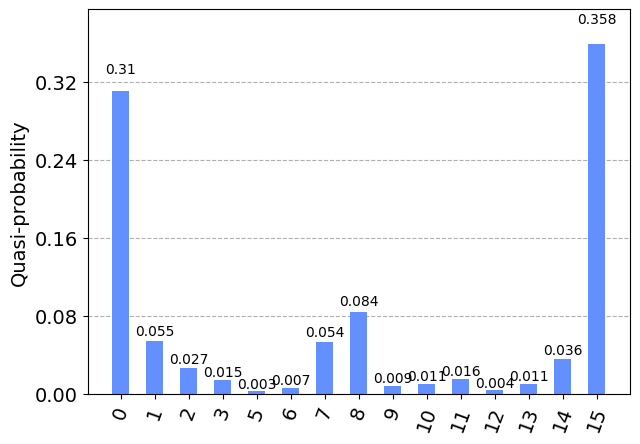

In [35]:
plot_distribution(job_sim_0.result().quasi_dists)

In [36]:
options = Options()
options.execution.shots = 1000
options.optimization_level = 3  # Levels 1-3 use Dynamical Decoupling
options.resilience_level = 1  # Level 1 uses TREX for error mitigation

with Session(service=service, backend=least_busy_backend) as session:
    sampler = Sampler(session=session, options=options)
    job_sim_1 = sampler.run(transpiled_qc)
    print(job_sim_1.result())
    session.close()


SamplerResult(quasi_dists=[{0: 0.919956367898767, 1: -0.226579504618147, 2: -0.193984811977366, 3: 0.079454871759224, 4: 0.00244382046172, 5: -0.002449365705128, 6: -0.013066255751683, 7: 0.017647337825661, 8: -0.133141278861541, 9: 0.030758235642653, 10: 0.034882914275908, 11: -0.013763650140982, 12: 0.040910355365778, 13: -0.134259645105717, 14: -0.176631778414696, 15: 0.767822387345547}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 55.39154490465406, 'readout_mitigation_time': 0.04970017122104764, 'warning': 'Optimization level clipped from 3 to 1'}])


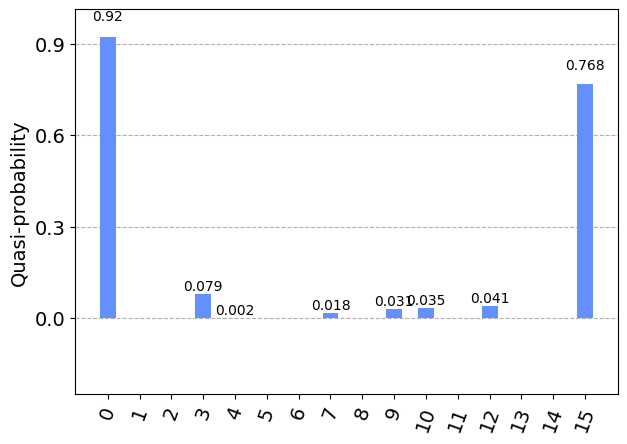

In [37]:
plot_distribution(job_sim_1.result().quasi_dists)